In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device: cuda
Epoch 001 | MSE=6373.653989
Epoch 002 | MSE=4237.193623
Epoch 003 | MSE=2859.120874
Epoch 004 | MSE=1877.833712
Epoch 005 | MSE=1190.995931
Epoch 006 | MSE=729.093901
Epoch 007 | MSE=428.864052
Epoch 008 | MSE=243.441326
Epoch 009 | MSE=134.854914
Epoch 010 | MSE=74.543853
Epoch 011 | MSE=43.183299
Epoch 012 | MSE=27.721865
Epoch 013 | MSE=20.585503
Epoch 014 | MSE=17.684815
Epoch 015 | MSE=16.416703
Epoch 016 | MSE=15.872333
Epoch 017 | MSE=15.753629
Epoch 018 | MSE=15.697933
Epoch 019 | MSE=15.763206
Epoch 020 | MSE=15.804700
Epoch 021 | MSE=15.642705
Epoch 022 | MSE=15.630090
Epoch 023 | MSE=15.704370
Epoch 024 | MSE=15.734548
Epoch 025 | MSE=15.585360
Epoch 026 | MSE=15.783486
Epoch 027 | MSE=15.644252
Epoch 028 | MSE=15.713148
Epoch 029 | MSE=15.690062
Epoch 030 | MSE=15.700709

=========== Block Missing Debug (LSTM) ===========
Deleted indices : [23, 24, 25, 26, 27]
True values     : [89.78559875488281, 89.48159790039062, 89.64949798583984, 89.76640319824219, 89.6011

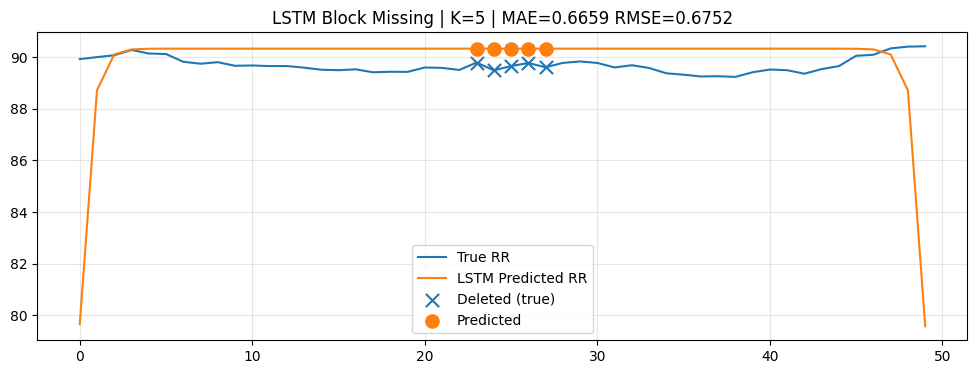

Saved LSTM model.


In [7]:
# ============================================================
# LSTM BASELINE — BLOCK MISSINGNESS (NO GAN)
# RR Interval Imputation
#
# - BLOCK missingness (K consecutive points)
# - Mean fill ONLY as input (not reported)
# - LSTM predicts full sequence
# - Evaluation ONLY on missing points
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

# -------------------------
# CONFIG
# -------------------------
WINDOW_LEN = 50
STRIDE     = 5
K_MISSING  = 5   # block length

BATCH_SIZE = 128
EPOCHS     = 30
LR         = 1e-3
SEED       = 42

# -------------------------
# Reproducibility
# -------------------------
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# Dummy RR records (REPLACE with your real rr_records)
# ============================================================
rr_records = []
for _ in range(54):
    L = np.random.randint(600, 1800)
    base = 90 + np.cumsum(np.random.randn(L) * 0.15)
    rr_records.append(base.astype(np.float32))

# ============================================================
# Dataset
# ============================================================
class RRWindowDataset(Dataset):
    def __init__(self, rr_records, window_len=50, stride=5):
        self.samples = []
        for r in rr_records:
            for i in range(0, len(r) - window_len + 1, stride):
                self.samples.append(r[i:i+window_len])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)

# ============================================================
# BLOCK missing mask + mean fill (input only)
# ============================================================
def make_block_missing(x, K):
    """
    x: (B,T)
    """
    B, T = x.shape
    m = torch.ones((B, T), device=x.device)
    idx_list = []

    for b in range(B):
        start = torch.randint(0, T-K+1, (1,)).item()
        idx = torch.arange(start, start+K)
        m[b, idx] = 0
        idx_list.append(idx)

    # Mean fill (input only)
    obs_sum = (x * m).sum(dim=1, keepdim=True)
    obs_cnt = m.sum(dim=1, keepdim=True).clamp(min=1)
    fill = obs_sum / obs_cnt
    x_filled = x * m + fill * (1 - m)

    return x_filled, m, idx_list

# ============================================================
# LSTM Model
# ============================================================
class LSTMImputer(nn.Module):
    def __init__(self, hidden=64, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden*2, 1)

    def forward(self, x):
        # x: (B,T)
        h, _ = self.lstm(x.unsqueeze(-1))
        return self.fc(h).squeeze(-1)

# ============================================================
# Train
# ============================================================
def train_lstm(rr_records):
    ds = RRWindowDataset(rr_records, WINDOW_LEN, STRIDE)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    model = LSTMImputer().to(device)
    opt = optim.Adam(model.parameters(), lr=LR)

    for ep in range(1, EPOCHS+1):
        model.train()
        loss_sum = 0

        for x in dl:
            x = x.to(device)
            x_fill, m, _ = make_block_missing(x, K_MISSING)

            pred = model(x_fill)

            # Missing-only loss
            loss = ((pred - x)**2 * (1-m)).sum() / (1-m).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item()

        print(f"Epoch {ep:03d} | MSE={loss_sum/len(dl):.6f}")

    return model

# ============================================================
# Inference + Debug
# ============================================================
@torch.no_grad()
def evaluate_one(model, rr_window):
    model.eval()

    x = torch.tensor(rr_window).unsqueeze(0).to(device)
    x_fill, m, idx_list = make_block_missing(x, K_MISSING)
    idx = idx_list[0].cpu().numpy()

    pred = model(x_fill).cpu().numpy()[0]
    true = rr_window

    err = np.abs(pred[idx] - true[idx])
    mae = err.mean()
    rmse = np.sqrt((err**2).mean())

    print("\n=========== Block Missing Debug (LSTM) ===========")
    print("Deleted indices :", idx.tolist())
    print("True values     :", np.round(true[idx],4).tolist())
    print("Predicted       :", np.round(pred[idx],4).tolist())
    print("Abs error       :", np.round(err,4).tolist())
    print(f"LSTM -> MAE={mae:.4f} | RMSE={rmse:.4f}")
    print("=================================================\n")

    return true, x_fill.cpu().numpy()[0], pred, idx, mae, rmse

# ============================================================
# Plot
# ============================================================
def plot_result(true, filled, pred, idx, title):
    plt.figure(figsize=(12,4))
    plt.plot(true, label="True RR")
    plt.plot(pred, label="LSTM Predicted RR")
    plt.scatter(idx, true[idx], marker="x", s=90, label="Deleted (true)")
    plt.scatter(idx, pred[idx], marker="o", s=90, label="Predicted")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(title)
    plt.show()

# ============================================================
# RUN
# ============================================================
model = train_lstm(rr_records)

test_seq = rr_records[0][:WINDOW_LEN]
true, filled, pred, idx, mae, rmse = evaluate_one(model, test_seq)

plot_result(
    true, filled, pred, idx,
    title=f"LSTM Block Missing | K={K_MISSING} | MAE={mae:.4f} RMSE={rmse:.4f}"
)

torch.save(model.state_dict(), "/kaggle/working/lstm_rr_block_missing.pt")
print("Saved LSTM model.")


Device: cuda
Loaded records: 54
Total windows: 12924
RR clamp range (0.5%..99.5%): [77.43, 100.72] (samples)
Epoch 001 | D=0.7371 | G=641.7239 | MissMAE=0.3462 | dRRloss=0.3251
Epoch 002 | D=0.0040 | G=701.2812 | MissMAE=0.3447 | dRRloss=0.3237
Epoch 003 | D=0.0032 | G=699.9718 | MissMAE=0.3396 | dRRloss=0.3178
Epoch 004 | D=0.0021 | G=691.4929 | MissMAE=0.2993 | dRRloss=0.2778
Epoch 005 | D=0.0016 | G=668.5526 | MissMAE=0.1868 | dRRloss=0.1668
Epoch 006 | D=0.0022 | G=659.8044 | MissMAE=0.1475 | dRRloss=0.1285
Epoch 007 | D=0.0011 | G=658.3779 | MissMAE=0.1353 | dRRloss=0.1162
Epoch 008 | D=0.0010 | G=656.0023 | MissMAE=0.1292 | dRRloss=0.1107
Epoch 009 | D=0.0009 | G=655.1161 | MissMAE=0.1241 | dRRloss=0.1059
Epoch 010 | D=-0.0014 | G=654.3712 | MissMAE=0.1205 | dRRloss=0.1034
Epoch 011 | D=0.0010 | G=654.0610 | MissMAE=0.1193 | dRRloss=0.1022
Epoch 012 | D=0.0015 | G=654.0575 | MissMAE=0.1181 | dRRloss=0.1014
Epoch 013 | D=0.0022 | G=652.3932 | MissMAE=0.1172 | dRRloss=0.1008
Epoch 

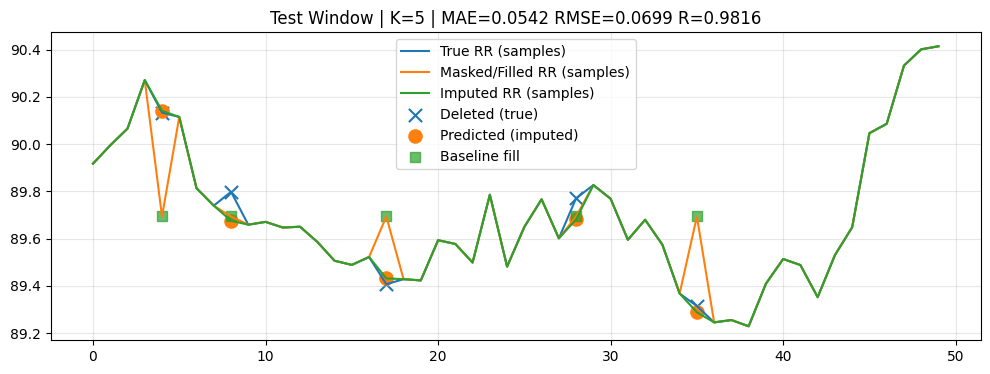

Saved: /kaggle/working/rr_imputer_lstm_wgangp_residual_with_R_HRV_units_fixed.pt


In [9]:
# ============================================================
# Kaggle Notebook (FULL CODE - ALL TOGETHER)  ✅ RR UNIT FIXED
# RR Interval Imputation with:
#   - LSTM Generator (predicts RESIDUAL over baseline fill)
#   - WGAN-GP Critic (1D CNN)
#   - Missing-only L1 loss (exact missing recovery)
#   - Physiology loss on dRR (prevents spikes)
#
# + DEBUG + METRICS:
#   ✅ Missing-only MAE + RMSE
#   ✅ Pearson R on missing points only
#   ✅ HRV feature errors (time-domain) on full window (IN MILLISECONDS):
#        meanRR(ms), SDNN(ms), RMSSD(ms), pNN50(%), meanHR(bpm), SDHR(bpm)
#
# IMPORTANT FIX:
#   RR values in NSR RR database are in "samples" at Fs=128 Hz.
#   Convert to milliseconds: RR_ms = RR_samples * (1000/128) = RR_samples*7.8125
# ============================================================

import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -------------------------
# CONFIG (edit as needed)
# -------------------------
DATASET_ROOT = "/kaggle/input/final-normal-sinus-dataset/normal-sinus-rhythm-rr-interval-database-1.0.0"

FS_HZ        = 128.0                    # ✅ sampling rate of annotations (samples/sec)
SAMPLE2MS    = 1000.0 / FS_HZ           # ✅ 7.8125 ms per sample

WINDOW_LEN   = 50
STRIDE       = 5
K_MISSING    = 5

BATCH_SIZE   = 128
EPOCHS       = 30
N_CRITIC     = 3

LR_G         = 2e-4
LR_D         = 2e-4

LAMBDA_MISS  = 200.0
LAMBDA_DRR   = 5.0
LAMBDA_SMOOTH= 0.02

GP_LAMBDA    = 10.0
FILL_MODE    = "mean"                  # "mean" or "ffill"

SEED         = 42

# -------------------------
# Reproducibility
# -------------------------
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# 0) RR unit conversion (samples -> ms)
# ============================================================
def rr_samples_to_ms(rr_samples):
    rr_samples = np.asarray(rr_samples, dtype=np.float64)
    return rr_samples * SAMPLE2MS

# ============================================================
# 1) LOAD YOUR RR RECORDS
# ============================================================
def load_rr_records(dataset_root: str):
    """
    Return: rr_records: List[np.ndarray] (RR in samples), dtype float32
    Implement this based on your dataset format.
    """
    rr_records = []

    # Example for .npy:
    # for fn in sorted(os.listdir(dataset_root)):
    #     if fn.endswith(".npy"):
    #         arr = np.load(os.path.join(dataset_root, fn)).astype(np.float32)
    #         rr_records.append(arr)

    if len(rr_records) == 0:
        raise RuntimeError(
            "load_rr_records() returned 0 records.\n"
            "Edit load_rr_records() to match your dataset format."
        )
    return rr_records

# ============================================================
# IMPORTANT:
# If you already built rr_records using WFDB earlier, keep that.
# Dummy fallback to let notebook run end-to-end (REMOVE for real data).
# ============================================================
rr_records = []
for _ in range(54):
    L = np.random.randint(600, 1800)
    base = 90 + np.cumsum(np.random.randn(L) * 0.15)  # smooth-ish RR in "samples"
    rr_records.append(base.astype(np.float32))
print("Loaded records:", len(rr_records))

# ============================================================
# 2) WINDOWING DATASET
# ============================================================
class RRWindowDataset(Dataset):
    def __init__(self, rr_records, window_len=50, stride=5):
        self.samples = []
        for rec in rr_records:
            rec = np.asarray(rec, dtype=np.float32)
            if len(rec) < window_len:
                continue
            for s in range(0, len(rec) - window_len + 1, stride):
                self.samples.append(rec[s:s+window_len])
        if len(self.samples) == 0:
            raise ValueError("No windows created. Reduce WINDOW_LEN/STRIDE or check data lengths.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)

# ============================================================
# 3) MASKING / FEATURES
# ============================================================
def make_mask_and_corrupt(x, K=5, fill_mode="mean"):
    B, T = x.shape
    m = torch.ones((B, T), device=x.device)
    idx_missing_list = []

    for b in range(B):
        idx = torch.randperm(T, device=x.device)[:K]
        m[b, idx] = 0.0
        idx_missing_list.append(idx)

    if fill_mode == "mean":
        obs_sum = (x * m).sum(dim=1, keepdim=True)
        obs_cnt = m.sum(dim=1, keepdim=True).clamp(min=1.0)
        fill = obs_sum / obs_cnt
        x_obs = x * m + fill * (1.0 - m)

    elif fill_mode == "ffill":
        x_obs = x.clone()
        for b in range(B):
            missing = (m[b] == 0)
            obs_idx = torch.where(m[b] == 1)[0]
            if len(obs_idx) == 0:
                continue
            prev = x_obs[b, obs_idx[0]].item()
            for t in range(T):
                if missing[t]:
                    x_obs[b, t] = prev
                else:
                    prev = x_obs[b, t].item()
    else:
        raise ValueError("fill_mode must be 'mean' or 'ffill'")

    return x_obs, m, idx_missing_list

def drr(x):
    dx = x[:, 1:] - x[:, :-1]
    dx = torch.cat([torch.zeros((x.size(0), 1), device=x.device), dx], dim=1)
    return dx

# ============================================================
# 3b) EXTRA METRICS: Correlation (R) + HRV feature errors (ms)
# ============================================================
def pearson_r(a, b, eps=1e-12):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    if a.size < 2 or b.size < 2:
        return 0.0
    a = a - a.mean()
    b = b - b.mean()
    denom = (np.sqrt((a*a).sum()) * np.sqrt((b*b).sum())) + eps
    if denom < 1e-9:
        return 0.0
    return float((a*b).sum() / denom)

def hrv_time_features_rr_ms(rr_ms):
    """
    rr_ms: RR intervals in milliseconds
    returns: meanRR(ms), SDNN(ms), RMSSD(ms), pNN50(%), meanHR(bpm), SDHR(bpm)
    """
    rr = np.asarray(rr_ms, dtype=np.float64)
    rr = rr[np.isfinite(rr)]
    if len(rr) < 3:
        return {
            "meanRR": np.nan, "SDNN": np.nan, "RMSSD": np.nan, "pNN50": np.nan,
            "meanHR": np.nan, "SDHR": np.nan
        }

    diff = np.diff(rr)
    meanRR = float(np.mean(rr))
    SDNN   = float(np.std(rr, ddof=1)) if len(rr) > 1 else np.nan
    RMSSD  = float(np.sqrt(np.mean(diff**2))) if len(diff) > 0 else np.nan
    pNN50  = float(np.mean(np.abs(diff) > 50.0) * 100.0) if len(diff) > 0 else np.nan

    hr = 60000.0 / rr  # bpm
    meanHR = float(np.mean(hr))
    SDHR   = float(np.std(hr, ddof=1)) if len(hr) > 1 else np.nan

    return {
        "meanRR": meanRR,
        "SDNN": SDNN,
        "RMSSD": RMSSD,
        "pNN50": pNN50,
        "meanHR": meanHR,
        "SDHR": SDHR
    }

def feature_errors(true_rr_samples, pred_rr_samples):
    """
    Convert BOTH sequences to ms then compute time-domain HRV errors.
    """
    true_ms = rr_samples_to_ms(true_rr_samples)
    pred_ms = rr_samples_to_ms(pred_rr_samples)

    ft = hrv_time_features_rr_ms(true_ms)
    fp = hrv_time_features_rr_ms(pred_ms)

    out = {}
    for k in ft.keys():
        t = ft[k]
        p = fp[k]
        if not np.isfinite(t) or not np.isfinite(p):
            out[k] = {"true": t, "pred": p, "abs_err": np.nan, "rel_err_%": np.nan}
        else:
            abs_err = float(np.abs(p - t))
            rel_err = float(abs_err / (np.abs(t) + 1e-12) * 100.0)
            out[k] = {"true": float(t), "pred": float(p), "abs_err": abs_err, "rel_err_%": rel_err}
    return out

# ============================================================
# 4) MODELS
# ============================================================
class LSTMGeneratorResidual(nn.Module):
    def __init__(self, hidden=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=hidden,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=True
        )
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x_base, m, noise):
        dx = drr(x_base)
        inp = torch.stack([x_base, m, dx, noise], dim=-1)
        h, _ = self.lstm(inp)
        delta = self.head(h).squeeze(-1)
        return delta

class CNNWganCritic(nn.Module):
    def __init__(self, channels=64, kernel=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, channels, kernel, padding=kernel//2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(channels, channels, kernel, padding=kernel//2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(channels, channels, kernel, padding=kernel//2),
            nn.LeakyReLU(0.2),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        h = self.net(x)
        h = self.pool(h).squeeze(-1)
        return self.fc(h).squeeze(-1)

# ============================================================
# 5) WGAN-GP gradient penalty
# ============================================================
def gradient_penalty(critic, real, fake, gp_lambda=10.0):
    B = real.size(0)
    eps = torch.rand(B, 1, device=real.device).expand_as(real)
    x_hat = eps * real + (1 - eps) * fake
    x_hat.requires_grad_(True)

    scores = critic(x_hat)
    grads = torch.autograd.grad(
        outputs=scores,
        inputs=x_hat,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grads = grads.view(B, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean() * gp_lambda
    return gp

# ============================================================
# 6) TRAIN
# ============================================================
def train_wgan(rr_records):
    ds = RRWindowDataset(rr_records, window_len=WINDOW_LEN, stride=STRIDE)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    print("Total windows:", len(ds))

    G = LSTMGeneratorResidual(hidden=64, num_layers=2, dropout=0.1).to(device)
    D = CNNWganCritic(channels=64, kernel=5).to(device)

    opt_g = optim.Adam(G.parameters(), lr=LR_G, betas=(0.5, 0.9))
    opt_d = optim.Adam(D.parameters(), lr=LR_D, betas=(0.5, 0.9))

    all_vals = np.concatenate([np.asarray(r, dtype=np.float32) for r in rr_records])
    lo, hi = np.percentile(all_vals, [0.5, 99.5]).astype(np.float32)
    lo, hi = float(lo), float(hi)
    print(f"RR clamp range (0.5%..99.5%): [{lo:.2f}, {hi:.2f}] (samples)")

    for ep in range(1, EPOCHS + 1):
        G.train(); D.train()
        d_sum = g_sum = miss_sum = drr_sum = 0.0

        for x in dl:
            x = x.to(device)

            # ---- Critic updates ----
            for _ in range(N_CRITIC):
                with torch.no_grad():
                    x_base, m, _ = make_mask_and_corrupt(x, K=K_MISSING, fill_mode=FILL_MODE)
                    noise = torch.rand_like(x) * (1.0 - m)
                    delta = G(x_base, m, noise)
                    x_hat = m * x + (1.0 - m) * (x_base + delta)
                    x_hat = torch.clamp(x_hat, lo, hi)

                real_score = D(x)
                fake_score = D(x_hat)
                gp = gradient_penalty(D, x, x_hat, gp_lambda=GP_LAMBDA)
                d_loss = (fake_score.mean() - real_score.mean()) + gp

                opt_d.zero_grad(set_to_none=True)
                d_loss.backward()
                opt_d.step()

            # ---- Generator update ----
            x_base, m, _ = make_mask_and_corrupt(x, K=K_MISSING, fill_mode=FILL_MODE)
            noise = torch.rand_like(x) * (1.0 - m)
            delta = G(x_base, m, noise)
            x_hat = m * x + (1.0 - m) * (x_base + delta)
            x_hat = torch.clamp(x_hat, lo, hi)

            adv = -D(x_hat).mean()

            denom = (1.0 - m).sum().clamp(min=1.0)
            miss_mae = (torch.abs(x_hat - x) * (1.0 - m)).sum() / denom

            m_pair = m[:, 1:] * m[:, :-1]
            miss_drr_mask = 1.0 - m_pair
            drr_hat = x_hat[:, 1:] - x_hat[:, :-1]
            drr_true = x[:, 1:] - x[:, :-1]
            denom_drr = miss_drr_mask.sum().clamp(min=1.0)
            drr_loss = (torch.abs(drr_hat - drr_true) * miss_drr_mask).sum() / denom_drr

            smooth = torch.mean(torch.abs(drr_hat))

            g_loss = adv + LAMBDA_MISS * miss_mae + LAMBDA_DRR * drr_loss + LAMBDA_SMOOTH * smooth

            opt_g.zero_grad(set_to_none=True)
            g_loss.backward()
            opt_g.step()

            d_sum += d_loss.item()
            g_sum += g_loss.item()
            miss_sum += miss_mae.item()
            drr_sum += drr_loss.item()

        print(
            f"Epoch {ep:03d} | D={d_sum/len(dl):.4f} | G={g_sum/len(dl):.4f} | "
            f"MissMAE={miss_sum/len(dl):.4f} | dRRloss={drr_sum/len(dl):.4f}"
        )

    return G, D, lo, hi

# ============================================================
# 7) INFERENCE + DEBUG PRINTS + R + HRV ERRORS (ms)
# ============================================================
@torch.no_grad()
def impute_one_window(G, rr_window, lo=None, hi=None, K=5, verbose=True):
    G.eval()
    x = torch.tensor(rr_window, dtype=torch.float32, device=device).unsqueeze(0)  # (1,T)
    x_base, m, idx_list = make_mask_and_corrupt(x, K=K, fill_mode=FILL_MODE)
    idx_missing = idx_list[0].detach().cpu().numpy()

    noise = torch.rand_like(x) * (1.0 - m)
    delta = G(x_base, m, noise)
    x_hat = m * x + (1.0 - m) * (x_base + delta)

    if lo is not None and hi is not None:
        x_hat = torch.clamp(x_hat, lo, hi)

    x_true = x.squeeze(0).cpu().numpy()
    x_base_np = x_base.squeeze(0).cpu().numpy()
    x_pred = x_hat.squeeze(0).cpu().numpy()

    # Missing-only
    idx_s = np.array(sorted(idx_missing), dtype=int)
    true_s = x_true[idx_s]
    pred_s = x_pred[idx_s]
    abs_err = np.abs(pred_s - true_s)
    mae = float(np.mean(abs_err))
    rmse = float(np.sqrt(np.mean((pred_s - true_s) ** 2)))
    r_missing = pearson_r(true_s, pred_s) if len(idx_s) >= 2 else 0.0

    # HRV errors (convert samples->ms inside)
    hrv_errs = feature_errors(x_true, x_pred)

    if verbose:
        print("\n================ Missing-value Debug ================")
        print(f"K={K} missing points")
        print("RR unit for MAE/RMSE here: SAMPLES (at 128 Hz)")
        print("Deleted indices     :", idx_s.tolist())
        print("Deleted TRUE values :", np.round(true_s, 4).tolist())
        print("Predicted values    :", np.round(pred_s, 4).tolist())
        print("Abs error           :", np.round(abs_err, 4).tolist())
        print(f"Missing-only MAE={mae:.6f} | RMSE={rmse:.6f} | R(missing)={r_missing:.6f}")
        print("-----------------------------------------------------")
        print("HRV feature errors (True vs Imputed, full window)  ✅ in ms/bpm:")
        for k, v in hrv_errs.items():
            t = v["true"]; p = v["pred"]; ae = v["abs_err"]; re = v["rel_err_%"]
            if np.isfinite(t) and np.isfinite(p):
                unit = "ms" if k in ["meanRR","SDNN","RMSSD"] else ("%" if k=="pNN50" else "bpm")
                print(f"  {k:6s} | true={t:.4f} {unit}  pred={p:.4f} {unit} | abs={ae:.4f} | rel%={re:.2f}")
            else:
                print(f"  {k:6s} | true={t} pred={p} | abs={ae} | rel%={re}")
        print("=====================================================\n")

    return x_true, x_base_np, x_pred, m.squeeze(0).cpu().numpy(), idx_missing, mae, rmse, r_missing, hrv_errs

def plot_imputation(x_true, x_base, x_imputed, idx_missing, title="RR Imputation"):
    plt.figure(figsize=(12,4))
    plt.plot(x_true, label="True RR (samples)")
    plt.plot(x_base, label="Masked/Filled RR (samples)")
    plt.plot(x_imputed, label="Imputed RR (samples)")
    plt.scatter(idx_missing, x_true[idx_missing], marker="x", s=90, label="Deleted (true)")
    plt.scatter(idx_missing, x_imputed[idx_missing], marker="o", s=90, label="Predicted (imputed)")
    plt.scatter(idx_missing, x_base[idx_missing], marker="s", s=60, label="Baseline fill", alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ============================================================
# 8) RUN
# ============================================================
G, D, lo, hi = train_wgan(rr_records)

test_seq = rr_records[0][:WINDOW_LEN]
x_true, x_base, x_imputed, m_np, idx_missing, mae, rmse, r_missing, hrv_errs = impute_one_window(
    G, test_seq, lo=lo, hi=hi, K=K_MISSING, verbose=True
)

plot_imputation(
    x_true, x_base, x_imputed, idx_missing,
    title=f"Test Window | K={K_MISSING} | MAE={mae:.4f} RMSE={rmse:.4f} R={r_missing:.4f}"
)

MODEL_PATH = "/kaggle/working/rr_imputer_lstm_wgangp_residual_with_R_HRV_units_fixed.pt"
torch.save({
    "G_state": G.state_dict(),
    "lo": lo,
    "hi": hi,
    "window_len": WINDOW_LEN,
    "k_missing": K_MISSING,
    "fs_hz": FS_HZ
}, MODEL_PATH)
print("Saved:", MODEL_PATH)


Device: cuda
Loaded records: 54
Subject split: train=38 val=8 test=8 (total=54)
Train subject IDs: [27, 7, 37, 40, 53, 17, 5, 51, 34, 23, 41, 29, 20, 18, 24, 39, 48, 45, 4, 25, 31, 26, 49, 9, 50, 21, 28, 44, 16, 46, 32, 15, 3, 30, 10, 42, 47, 6]
Val subject IDs  : [38, 11, 22, 19, 35, 0, 12, 43]
Test subject IDs : [14, 52, 2, 36, 33, 1, 13, 8]
Train windows: 9108
RR clamp range (0.5%..99.5%): [76.95, 98.34] (samples) [train-only]
Epoch 001 | D=1.0266 | G=614.0435 | MissMAE=0.3427 | dRRloss=0.3233 || VAL: MAE=0.4101 RMSE=0.4654 R=0.0554
Epoch 002 | D=0.0011 | G=697.7016 | MissMAE=0.3414 | dRRloss=0.3211 || VAL: MAE=0.4138 RMSE=0.4670 R=0.2464
Epoch 003 | D=-0.0009 | G=698.2183 | MissMAE=0.3406 | dRRloss=0.3206 || VAL: MAE=0.4038 RMSE=0.4573 R=0.5265
Epoch 004 | D=0.0054 | G=696.9608 | MissMAE=0.3369 | dRRloss=0.3170 || VAL: MAE=0.3989 RMSE=0.4497 R=0.6723
Epoch 005 | D=0.0021 | G=692.3653 | MissMAE=0.3173 | dRRloss=0.2978 || VAL: MAE=0.3582 RMSE=0.4067 R=0.7618
Epoch 006 | D=0.0010 | G=

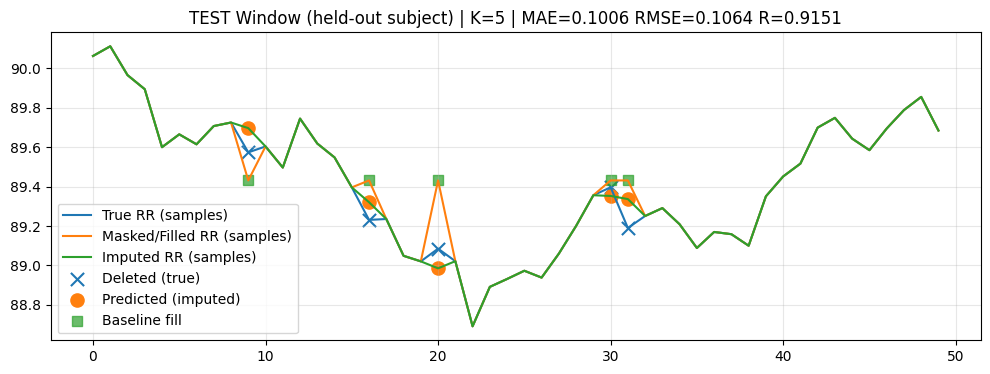

Saved: /kaggle/working/rr_imputer_lstm_wgangp_subject_split_units_fixed.pt


In [10]:
# ============================================================
# Kaggle Notebook (FULL CODE - SUBJECT-LEVEL SPLIT) ✅ RR UNIT FIXED
# RR Interval Imputation with:
#   - LSTM Generator (predicts RESIDUAL over baseline fill)
#   - WGAN-GP Critic (1D CNN)
#   - Missing-only L1 loss (exact missing recovery)
#   - Physiology loss on dRR (prevents spikes)
#
# + DEBUG + METRICS:
#   ✅ Missing-only MAE + RMSE
#   ✅ Pearson R on missing points only
#   ✅ HRV feature errors (time-domain) on full window (IN MILLISECONDS):
#        meanRR(ms), SDNN(ms), RMSSD(ms), pNN50(%), meanHR(bpm), SDHR(bpm)
#
# IMPORTANT FIX:
#   RR values in NSR RR database are in "samples" at Fs=128 Hz.
#   Convert to milliseconds: RR_ms = RR_samples * (1000/128) = RR_samples*7.8125
#
# SUBJECT-LEVEL SPLIT (NO SUBJECT LEAKAGE):
#   70% subjects -> train
#   15% subjects -> val
#   15% subjects -> test
#   (split is on RECORDS, not windows)
# ============================================================

import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -------------------------
# CONFIG (edit as needed)
# -------------------------
DATASET_ROOT = "/kaggle/input/final-normal-sinus-dataset/normal-sinus-rhythm-rr-interval-database-1.0.0"

FS_HZ        = 128.0
SAMPLE2MS    = 1000.0 / FS_HZ

WINDOW_LEN   = 50
STRIDE       = 5
K_MISSING    = 5

BATCH_SIZE   = 128
EPOCHS       = 30
N_CRITIC     = 3

LR_G         = 2e-4
LR_D         = 2e-4

LAMBDA_MISS  = 200.0
LAMBDA_DRR   = 5.0
LAMBDA_SMOOTH= 0.02

GP_LAMBDA    = 10.0
FILL_MODE    = "mean"  # internal fill for generator input

SEED         = 42

TRAIN_FRAC   = 0.70
VAL_FRAC     = 0.15
TEST_FRAC    = 0.15

# -------------------------
# Reproducibility
# -------------------------
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# 0) RR unit conversion (samples -> ms)
# ============================================================
def rr_samples_to_ms(rr_samples):
    rr_samples = np.asarray(rr_samples, dtype=np.float64)
    return rr_samples * SAMPLE2MS

# ============================================================
# 1) LOAD YOUR RR RECORDS (IN SAMPLES)
# ============================================================
def load_rr_records(dataset_root: str):
    """
    Return: rr_records: List[np.ndarray] (RR in samples), dtype float32

    ⚠️ Replace this function with your real loader (WFDB / CSV / NPY).
    """
    rr_records = []

    # Example for .npy:
    # for fn in sorted(os.listdir(dataset_root)):
    #     if fn.endswith(".npy"):
    #         arr = np.load(os.path.join(dataset_root, fn)).astype(np.float32)
    #         rr_records.append(arr)

    if len(rr_records) == 0:
        raise RuntimeError(
            "load_rr_records() returned 0 records.\n"
            "Edit load_rr_records() to match your dataset format."
        )
    return rr_records

# ============================================================
# IMPORTANT:
# If you already built rr_records using WFDB earlier, use that and comment this.
# Dummy fallback to let notebook run end-to-end (REMOVE for real data).
# ============================================================
rr_records = []
for _ in range(54):
    L = np.random.randint(600, 1800)
    base = 90 + np.cumsum(np.random.randn(L) * 0.15)  # RR in "samples"
    rr_records.append(base.astype(np.float32))
print("Loaded records:", len(rr_records))

# ============================================================
# 1b) SUBJECT-LEVEL SPLIT (records -> train/val/test)
# ============================================================
def split_subjects(rr_records, train_frac=0.70, val_frac=0.15, test_frac=0.15, seed=42):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-9, "Fractions must sum to 1.0"
    n = len(rr_records)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)

    n_train = int(round(n * train_frac))
    n_val   = int(round(n * val_frac))
    # ensure all subjects assigned
    n_train = min(max(n_train, 1), n-2) if n >= 3 else max(1, n_train)
    n_val   = min(max(n_val, 1), n-1-n_train) if n >= 3 else max(0, n_val)

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]

    train_recs = [rr_records[i] for i in train_idx]
    val_recs   = [rr_records[i] for i in val_idx]
    test_recs  = [rr_records[i] for i in test_idx]

    return train_recs, val_recs, test_recs, train_idx, val_idx, test_idx

train_records, val_records, test_records, tr_idx, va_idx, te_idx = split_subjects(
    rr_records, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=SEED
)

print(f"Subject split: train={len(train_records)} val={len(val_records)} test={len(test_records)} (total={len(rr_records)})")
print("Train subject IDs:", tr_idx.tolist())
print("Val subject IDs  :", va_idx.tolist())
print("Test subject IDs :", te_idx.tolist())

# ============================================================
# 2) WINDOWING DATASET (BUILT FROM SUBJECT SPLITS)
# ============================================================
class RRWindowDataset(Dataset):
    def __init__(self, rr_records, window_len=50, stride=5):
        self.samples = []
        for rec in rr_records:
            rec = np.asarray(rec, dtype=np.float32)
            if len(rec) < window_len:
                continue
            for s in range(0, len(rec) - window_len + 1, stride):
                self.samples.append(rec[s:s+window_len])
        if len(self.samples) == 0:
            raise ValueError("No windows created. Reduce WINDOW_LEN/STRIDE or check data lengths.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)

# ============================================================
# 3) MASKING / FEATURES (RANDOM missing)
# ============================================================
def make_mask_and_corrupt(x, K=5, fill_mode="mean"):
    B, T = x.shape
    m = torch.ones((B, T), device=x.device)
    idx_missing_list = []

    for b in range(B):
        idx = torch.randperm(T, device=x.device)[:K]
        m[b, idx] = 0.0
        idx_missing_list.append(idx)

    if fill_mode == "mean":
        obs_sum = (x * m).sum(dim=1, keepdim=True)
        obs_cnt = m.sum(dim=1, keepdim=True).clamp(min=1.0)
        fill = obs_sum / obs_cnt
        x_obs = x * m + fill * (1.0 - m)

    elif fill_mode == "ffill":
        x_obs = x.clone()
        for b in range(B):
            missing = (m[b] == 0)
            obs_idx = torch.where(m[b] == 1)[0]
            if len(obs_idx) == 0:
                continue
            prev = x_obs[b, obs_idx[0]].item()
            for t in range(T):
                if missing[t]:
                    x_obs[b, t] = prev
                else:
                    prev = x_obs[b, t].item()
    else:
        raise ValueError("fill_mode must be 'mean' or 'ffill'")

    return x_obs, m, idx_missing_list

def drr(x):
    dx = x[:, 1:] - x[:, :-1]
    dx = torch.cat([torch.zeros((x.size(0), 1), device=x.device), dx], dim=1)
    return dx

# ============================================================
# 3b) EXTRA METRICS: Correlation (R) + HRV feature errors (ms)
# ============================================================
def pearson_r(a, b, eps=1e-12):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    if a.size < 2 or b.size < 2:
        return 0.0
    a = a - a.mean()
    b = b - b.mean()
    denom = (np.sqrt((a*a).sum()) * np.sqrt((b*b).sum())) + eps
    if denom < 1e-9:
        return 0.0
    return float((a*b).sum() / denom)

def hrv_time_features_rr_ms(rr_ms):
    rr = np.asarray(rr_ms, dtype=np.float64)
    rr = rr[np.isfinite(rr)]
    if len(rr) < 3:
        return {
            "meanRR": np.nan, "SDNN": np.nan, "RMSSD": np.nan, "pNN50": np.nan,
            "meanHR": np.nan, "SDHR": np.nan
        }

    diff = np.diff(rr)
    meanRR = float(np.mean(rr))
    SDNN   = float(np.std(rr, ddof=1)) if len(rr) > 1 else np.nan
    RMSSD  = float(np.sqrt(np.mean(diff**2))) if len(diff) > 0 else np.nan
    pNN50  = float(np.mean(np.abs(diff) > 50.0) * 100.0) if len(diff) > 0 else np.nan

    hr = 60000.0 / rr
    meanHR = float(np.mean(hr))
    SDHR   = float(np.std(hr, ddof=1)) if len(hr) > 1 else np.nan

    return {
        "meanRR": meanRR,
        "SDNN": SDNN,
        "RMSSD": RMSSD,
        "pNN50": pNN50,
        "meanHR": meanHR,
        "SDHR": SDHR
    }

def feature_errors(true_rr_samples, pred_rr_samples):
    true_ms = rr_samples_to_ms(true_rr_samples)
    pred_ms = rr_samples_to_ms(pred_rr_samples)

    ft = hrv_time_features_rr_ms(true_ms)
    fp = hrv_time_features_rr_ms(pred_ms)

    out = {}
    for k in ft.keys():
        t = ft[k]
        p = fp[k]
        if not np.isfinite(t) or not np.isfinite(p):
            out[k] = {"true": t, "pred": p, "abs_err": np.nan, "rel_err_%": np.nan}
        else:
            abs_err = float(np.abs(p - t))
            rel_err = float(abs_err / (np.abs(t) + 1e-12) * 100.0)
            out[k] = {"true": float(t), "pred": float(p), "abs_err": abs_err, "rel_err_%": rel_err}
    return out

# ============================================================
# 4) MODELS
# ============================================================
class LSTMGeneratorResidual(nn.Module):
    def __init__(self, hidden=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=hidden,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=True
        )
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x_base, m, noise):
        dx = drr(x_base)
        inp = torch.stack([x_base, m, dx, noise], dim=-1)
        h, _ = self.lstm(inp)
        delta = self.head(h).squeeze(-1)
        return delta

class CNNWganCritic(nn.Module):
    def __init__(self, channels=64, kernel=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, channels, kernel, padding=kernel//2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(channels, channels, kernel, padding=kernel//2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(channels, channels, kernel, padding=kernel//2),
            nn.LeakyReLU(0.2),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        h = self.net(x)
        h = self.pool(h).squeeze(-1)
        return self.fc(h).squeeze(-1)

# ============================================================
# 5) WGAN-GP gradient penalty
# ============================================================
def gradient_penalty(critic, real, fake, gp_lambda=10.0):
    B = real.size(0)
    eps = torch.rand(B, 1, device=real.device).expand_as(real)
    x_hat = eps * real + (1 - eps) * fake
    x_hat.requires_grad_(True)

    scores = critic(x_hat)
    grads = torch.autograd.grad(
        outputs=scores,
        inputs=x_hat,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grads = grads.view(B, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean() * gp_lambda
    return gp

# ============================================================
# 6) TRAIN (train set only) + EVAL on VAL each epoch
# ============================================================
@torch.no_grad()
def evaluate_model(G, rr_records_eval, lo=None, hi=None, K=5, n_windows=400):
    """
    Evaluates by sampling up to n_windows windows from rr_records_eval.
    Returns mean MAE/RMSE/R and mean abs HRV feature errors.
    """
    ds = RRWindowDataset(rr_records_eval, window_len=WINDOW_LEN, stride=STRIDE)
    if len(ds) == 0:
        return None

    G.eval()
    idxs = np.arange(len(ds))
    np.random.default_rng(SEED).shuffle(idxs)
    idxs = idxs[:min(n_windows, len(ds))]

    maes, rmses, rs = [], [], []
    feat_abs = {k: [] for k in ["meanRR","SDNN","RMSSD","pNN50","meanHR","SDHR"]}

    for i in idxs:
        rr_window = ds[i].cpu().numpy()
        x = torch.tensor(rr_window, dtype=torch.float32, device=device).unsqueeze(0)
        x_base, m, idx_list = make_mask_and_corrupt(x, K=K, fill_mode=FILL_MODE)
        idx_missing = idx_list[0].detach().cpu().numpy()
        noise = torch.rand_like(x) * (1.0 - m)
        delta = G(x_base, m, noise)
        x_hat = m * x + (1.0 - m) * (x_base + delta)
        if (lo is not None) and (hi is not None):
            x_hat = torch.clamp(x_hat, lo, hi)

        x_true = x.squeeze(0).detach().cpu().numpy()
        x_pred = x_hat.squeeze(0).detach().cpu().numpy()

        idx_s = np.array(sorted(idx_missing), dtype=int)
        true_s = x_true[idx_s]
        pred_s = x_pred[idx_s]

        abs_err = np.abs(pred_s - true_s)
        maes.append(float(np.mean(abs_err)))
        rmses.append(float(np.sqrt(np.mean((pred_s - true_s)**2))))
        rs.append(pearson_r(true_s, pred_s) if len(idx_s) >= 2 else 0.0)

        hrv_errs = feature_errors(x_true, x_pred)
        for k in feat_abs.keys():
            ae = hrv_errs[k]["abs_err"]
            if np.isfinite(ae):
                feat_abs[k].append(float(ae))

    out = {
        "MAE_samples": float(np.mean(maes)),
        "RMSE_samples": float(np.mean(rmses)),
        "R_missing": float(np.mean(rs)),
        "HRV_abs_err": {k: (float(np.mean(v)) if len(v) else np.nan) for k, v in feat_abs.items()}
    }
    return out

def train_wgan(train_records, val_records):
    train_ds = RRWindowDataset(train_records, window_len=WINDOW_LEN, stride=STRIDE)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    print("Train windows:", len(train_ds))

    G = LSTMGeneratorResidual(hidden=64, num_layers=2, dropout=0.1).to(device)
    D = CNNWganCritic(channels=64, kernel=5).to(device)

    opt_g = optim.Adam(G.parameters(), lr=LR_G, betas=(0.5, 0.9))
    opt_d = optim.Adam(D.parameters(), lr=LR_D, betas=(0.5, 0.9))

    # clamp range computed ONLY from train subjects (avoid leakage)
    all_train_vals = np.concatenate([np.asarray(r, dtype=np.float32) for r in train_records])
    lo, hi = np.percentile(all_train_vals, [0.5, 99.5]).astype(np.float32)
    lo, hi = float(lo), float(hi)
    print(f"RR clamp range (0.5%..99.5%): [{lo:.2f}, {hi:.2f}] (samples) [train-only]")

    best_val = None
    best_state = None

    for ep in range(1, EPOCHS + 1):
        G.train(); D.train()
        d_sum = g_sum = miss_sum = drr_sum = 0.0

        for x in train_dl:
            x = x.to(device)

            # ---- Critic updates ----
            for _ in range(N_CRITIC):
                with torch.no_grad():
                    x_base, m, _ = make_mask_and_corrupt(x, K=K_MISSING, fill_mode=FILL_MODE)
                    noise = torch.rand_like(x) * (1.0 - m)
                    delta = G(x_base, m, noise)
                    x_hat = m * x + (1.0 - m) * (x_base + delta)
                    x_hat = torch.clamp(x_hat, lo, hi)

                real_score = D(x)
                fake_score = D(x_hat)
                gp = gradient_penalty(D, x, x_hat, gp_lambda=GP_LAMBDA)
                d_loss = (fake_score.mean() - real_score.mean()) + gp

                opt_d.zero_grad(set_to_none=True)
                d_loss.backward()
                opt_d.step()

            # ---- Generator update ----
            x_base, m, _ = make_mask_and_corrupt(x, K=K_MISSING, fill_mode=FILL_MODE)
            noise = torch.rand_like(x) * (1.0 - m)
            delta = G(x_base, m, noise)
            x_hat = m * x + (1.0 - m) * (x_base + delta)
            x_hat = torch.clamp(x_hat, lo, hi)

            adv = -D(x_hat).mean()

            denom = (1.0 - m).sum().clamp(min=1.0)
            miss_mae = (torch.abs(x_hat - x) * (1.0 - m)).sum() / denom

            m_pair = m[:, 1:] * m[:, :-1]
            miss_drr_mask = 1.0 - m_pair
            drr_hat = x_hat[:, 1:] - x_hat[:, :-1]
            drr_true = x[:, 1:] - x[:, :-1]
            denom_drr = miss_drr_mask.sum().clamp(min=1.0)
            drr_loss = (torch.abs(drr_hat - drr_true) * miss_drr_mask).sum() / denom_drr

            smooth = torch.mean(torch.abs(drr_hat))
            g_loss = adv + LAMBDA_MISS * miss_mae + LAMBDA_DRR * drr_loss + LAMBDA_SMOOTH * smooth

            opt_g.zero_grad(set_to_none=True)
            g_loss.backward()
            opt_g.step()

            d_sum += d_loss.item()
            g_sum += g_loss.item()
            miss_sum += miss_mae.item()
            drr_sum += drr_loss.item()

        # ---- Val evaluation each epoch (fast) ----
        val_metrics = evaluate_model(G, val_records, lo=lo, hi=hi, K=K_MISSING, n_windows=400) if len(val_records) else None

        msg = (
            f"Epoch {ep:03d} | D={d_sum/len(train_dl):.4f} | G={g_sum/len(train_dl):.4f} | "
            f"MissMAE={miss_sum/len(train_dl):.4f} | dRRloss={drr_sum/len(train_dl):.4f}"
        )
        if val_metrics is not None:
            msg += (
                f" || VAL: MAE={val_metrics['MAE_samples']:.4f} RMSE={val_metrics['RMSE_samples']:.4f} "
                f"R={val_metrics['R_missing']:.4f}"
            )
            # select best by VAL MAE
            if (best_val is None) or (val_metrics["MAE_samples"] < best_val):
                best_val = val_metrics["MAE_samples"]
                best_state = {k: v.detach().cpu().clone() for k, v in G.state_dict().items()}

        print(msg)

    # restore best model if available
    if best_state is not None:
        G.load_state_dict(best_state)
        print(f"Restored BEST model by VAL MAE: {best_val:.6f} (samples)")

    return G, D, lo, hi

# ============================================================
# 7) INFERENCE + DEBUG PRINTS + R + HRV ERRORS (ms)
# ============================================================
@torch.no_grad()
def impute_one_window(G, rr_window, lo=None, hi=None, K=5, verbose=True):
    G.eval()
    x = torch.tensor(rr_window, dtype=torch.float32, device=device).unsqueeze(0)  # (1,T)
    x_base, m, idx_list = make_mask_and_corrupt(x, K=K, fill_mode=FILL_MODE)
    idx_missing = idx_list[0].detach().cpu().numpy()

    noise = torch.rand_like(x) * (1.0 - m)
    delta = G(x_base, m, noise)
    x_hat = m * x + (1.0 - m) * (x_base + delta)

    if lo is not None and hi is not None:
        x_hat = torch.clamp(x_hat, lo, hi)

    x_true = x.squeeze(0).cpu().numpy()
    x_base_np = x_base.squeeze(0).cpu().numpy()
    x_pred = x_hat.squeeze(0).cpu().numpy()

    idx_s = np.array(sorted(idx_missing), dtype=int)
    true_s = x_true[idx_s]
    pred_s = x_pred[idx_s]
    abs_err = np.abs(pred_s - true_s)
    mae = float(np.mean(abs_err))
    rmse = float(np.sqrt(np.mean((pred_s - true_s) ** 2)))
    r_missing = pearson_r(true_s, pred_s) if len(idx_s) >= 2 else 0.0

    hrv_errs = feature_errors(x_true, x_pred)

    if verbose:
        print("\n================ Missing-value Debug ================")
        print(f"K={K} missing points")
        print("RR unit for MAE/RMSE here: SAMPLES (at 128 Hz)")
        print("Deleted indices     :", idx_s.tolist())
        print("Deleted TRUE values :", np.round(true_s, 4).tolist())
        print("Predicted values    :", np.round(pred_s, 4).tolist())
        print("Abs error           :", np.round(abs_err, 4).tolist())
        print(f"Missing-only MAE={mae:.6f} | RMSE={rmse:.6f} | R(missing)={r_missing:.6f}")
        print("-----------------------------------------------------")
        print("HRV feature errors (True vs Imputed, full window)  ✅ in ms/bpm:")
        for k, v in hrv_errs.items():
            t = v["true"]; p = v["pred"]; ae = v["abs_err"]; re = v["rel_err_%"]
            if np.isfinite(t) and np.isfinite(p):
                unit = "ms" if k in ["meanRR","SDNN","RMSSD"] else ("%" if k=="pNN50" else "bpm")
                print(f"  {k:6s} | true={t:.4f} {unit}  pred={p:.4f} {unit} | abs={ae:.4f} | rel%={re:.2f}")
            else:
                print(f"  {k:6s} | true={t} pred={p} | abs={ae} | rel%={re}")
        print("=====================================================\n")

    return x_true, x_base_np, x_pred, m.squeeze(0).cpu().numpy(), idx_missing, mae, rmse, r_missing, hrv_errs

def plot_imputation(x_true, x_base, x_imputed, idx_missing, title="RR Imputation"):
    plt.figure(figsize=(12,4))
    plt.plot(x_true, label="True RR (samples)")
    plt.plot(x_base, label="Masked/Filled RR (samples)")
    plt.plot(x_imputed, label="Imputed RR (samples)")
    plt.scatter(idx_missing, x_true[idx_missing], marker="x", s=90, label="Deleted (true)")
    plt.scatter(idx_missing, x_imputed[idx_missing], marker="o", s=90, label="Predicted (imputed)")
    plt.scatter(idx_missing, x_base[idx_missing], marker="s", s=60, label="Baseline fill", alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ============================================================
# 8) RUN: TRAIN on TRAIN subjects, pick best on VAL, report TEST
# ============================================================
G, D, lo, hi = train_wgan(train_records, val_records)

# ---- Evaluate on TEST subjects (aggregate) ----
test_metrics = evaluate_model(G, test_records, lo=lo, hi=hi, K=K_MISSING, n_windows=800) if len(test_records) else None
if test_metrics is not None:
    print("\n================ TEST (subject-level held-out) ================")
    print(f"TEST MAE (samples) : {test_metrics['MAE_samples']:.6f}")
    print(f"TEST RMSE (samples): {test_metrics['RMSE_samples']:.6f}")
    print(f"TEST R (missing)   : {test_metrics['R_missing']:.6f}")
    print("TEST HRV abs errors (units: ms/%/bpm):")
    for k, v in test_metrics["HRV_abs_err"].items():
        unit = "ms" if k in ["meanRR","SDNN","RMSSD"] else ("%" if k=="pNN50" else "bpm")
        print(f"  {k:6s}: {v:.6f} {unit}")
    print("==============================================================\n")

# ---- Debug plot on one TEST window (true held-out subject) ----
if len(test_records) > 0:
    # choose one test subject and one window from it
    test_ds = RRWindowDataset([test_records[0]], window_len=WINDOW_LEN, stride=STRIDE)
    test_seq = test_ds[0].cpu().numpy()

    x_true, x_base, x_imputed, m_np, idx_missing, mae, rmse, r_missing, hrv_errs = impute_one_window(
        G, test_seq, lo=lo, hi=hi, K=K_MISSING, verbose=True
    )

    plot_imputation(
        x_true, x_base, x_imputed, idx_missing,
        title=f"TEST Window (held-out subject) | K={K_MISSING} | MAE={mae:.4f} RMSE={rmse:.4f} R={r_missing:.4f}"
    )

# Save model + split indices for reproducibility
MODEL_PATH = "/kaggle/working/rr_imputer_lstm_wgangp_subject_split_units_fixed.pt"
torch.save({
    "G_state": G.state_dict(),
    "lo": lo,
    "hi": hi,
    "window_len": WINDOW_LEN,
    "k_missing": K_MISSING,
    "fs_hz": FS_HZ,
    "seed": SEED,
    "train_subject_ids": tr_idx,
    "val_subject_ids": va_idx,
    "test_subject_ids": te_idx
}, MODEL_PATH)
print("Saved:", MODEL_PATH)
